# Homework 2, *part 1* (40 points)

This warm-up problem set is provided to help you get used to PyTorch.

Please, only fill parts marked with "`Your code here`".

In [312]:
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

import torch
assert torch.__version__ >= '1.0.0'

To learn best practices $-$ for example,

* how to choose between `.sqrt()` and `.sqrt_()`,
* when to use `.view()` and how is it different from `.reshape()`,
* which `dtype` to use,

$-$ you are expected to google a lot, read tutorials on the Web and study documentation.

Quick documentation on functions and modules is available with `?` and `help()`, like so:

## Task 1 (3 points)

Use tensors only: **no lists, loops, numpy arrays etc.**

*Clarification update:*

1. *you mustn't emulate PyTorch tensors with lists or tuples. Using a list for scaffolding utilities not provided by PyTorch core (e.g. to store model's layers or to group function arguments) is OK;*
2. *no loops*;
3. *you mustn't use numpy or other tensor libraries except PyTorch.*

$\rho(\theta)$ is defined in polar coordinate system:

$$\rho(\theta) = (1 + 0.9 \cdot \cos{8\theta} ) \cdot (1 + 0.1 \cdot \cos{24\theta}) \cdot (0.9 + 0.05 \cdot \cos {200\theta}) \cdot (1 + \sin{\theta})$$

1. Create a regular grid of 1000 values of $\theta$ between $-\pi$ and $\pi$.
2. Compute $\rho(\theta)$ at these values.
3. Convert it into Cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)).

In [313]:
# (1) Your code here
theta = torch.arange(-math.pi, math.pi, 2*math.pi/1000) 
assert theta.shape == (1000,)

# (2) Your code here
multip1 = torch.add(torch.mul(torch.cos(torch.mul(theta,8)),  0.9),    1)
multip2 = torch.add(torch.mul(torch.cos(torch.mul(theta,24)), 0.1),    1)
multip3 = torch.add(torch.mul(torch.cos(torch.mul(theta,200)),0.05), 0.9)
multip4 = torch.add(torch.sin(theta),                                  1)
rho = torch.mul(torch.mul((torch.mul(multip3, multip4)), multip2), multip1)
assert torch.is_same_size(rho, theta)

# (3) Your code here
x = torch.mul(rho, torch.cos(theta))
y = torch.mul(rho, torch.sin(theta))

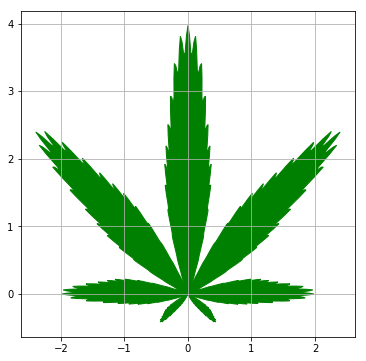

In [314]:
# Run this cell and make sure the plot is correct
plt.figure(figsize=[6,6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

## Task 2 (7 points)

Use tensors only: **no lists, loops, numpy arrays etc.**

*Clarification update: see task 1.*

We will implement [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway's_Game_of_Life) in PyTorch.

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)

If you skipped the URL above, here are the rules:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* At one step in time, the generation update happens:
  * Any living cell that has 2 or 3 neighbors survives, otherwise (0,1 or 4+ neighbors) it dies
  * Any cell with exactly 3 neighbors becomes alive if it was dead

You are given a reference numpy implementation of the update step. Your task is to convert it to PyTorch.

In [315]:
from scipy.signal import correlate2d as conv2d

def numpy_update(alive_map):
    # Count neighbours with convolution
    conv_kernel = np.array([[1,1,1],
                            [1,0,1],
                            [1,1,1]])
    
    num_alive_neighbors = conv2d(alive_map, conv_kernel, mode='same')
    
    # Apply game rules
    born = np.logical_and(num_alive_neighbors == 3, alive_map == 0)
    survived = np.logical_and(np.isin(num_alive_neighbors, [2,3]), alive_map == 1)
    
    np.copyto(alive_map, np.logical_or(born, survived))

In [316]:
def torch_update(alive_map):
    """
    Game of Life update function that does to `alive_map` exactly the same as `numpy_update`.
    
    :param alive_map: `torch.tensor` of shape `(height, width)` and dtype `torch.float32`
        containing 0s (dead) an 1s (alive)
    """
    # Your code here
    conv_kernel = torch.FloatTensor([[1,1,1],
                                [1,0,1],
                                [1,1,1]])
    conv_kernel = conv_kernel[None, None]
    alive_map = alive_map[None, None]
    
    num_alive_neighbors = torch.nn.functional.conv2d(alive_map, conv_kernel, padding=1)
 
    born = (num_alive_neighbors==3) & (alive_map==0)
    survived = ((num_alive_neighbors==2) | (num_alive_neighbors==3)) & (alive_map==1)
    alive_map[:] = born | survived
    
    updated = (born | survived)
    
    return updated.data.type(torch.FloatTensor)

    

In [317]:
# Generate a random initial map
alive_map_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(100, 100))
alive_map_torch = torch.tensor(alive_map_numpy).float().clone()

numpy_update(alive_map_numpy)
torch_update(alive_map_torch)

# results should be identical
assert np.allclose(alive_map_torch.numpy(), alive_map_numpy), \
    "Your PyTorch implementation doesn't match numpy_update."
print("Well done!")

Well done!


In [318]:
# %matplotlib notebook
# plt.ion()

# # initialize game field
# alive_map = np.random.choice([0, 1], size=(100, 100))
# alive_map = torch.tensor(alive_map).float()

# fig = plt.figure()
# ax = fig.add_subplot(111)
# fig.show()

# for _ in range(100):
#     torch_update(alive_map)
    
#     # re-draw image
#     ax.clear()
#     ax.imshow(alive_map.numpy(), cmap='gray')
#     fig.canvas.draw()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

## Task 3 (30 points)

You have to solve yet another character recognition problem: 10 letters, ~14 000 train samples.

For this, we ask you to build a multilayer perceptron (*i.e. a neural network of linear layers*) from scratch using **low-level** PyTorch interface.

Requirements:
1. at least 82% accuracy
2. at least 2 linear layers
3. use [softmax followed by categorical cross-entropy](https://gombru.github.io/2018/05/23/cross_entropy_loss/)

**You are NOT allowed to use**
* numpy arrays
* `torch.nn`, `torch.optim`, `torch.utils.data.DataLoader`
* convolutions

##### Clarification update:

1. *you mustn't emulate PyTorch tensors with lists or tuples. Using a list for scaffolding utilities not provided by PyTorch core (e.g. to store model's layers or to group function arguments) is OK;*
2. *you mustn't use numpy or other tensor libraries except PyTorch;*
3. *the purpose of part 1 is to make you google and read the documentation a LOT so that you learn which intrinsics PyTorch provides and what are their interfaces. This is why if there is some tensor functionality that is directly native to PyTorch, you mustn't emulate it with loops. Example:*

```
x = torch.rand(1_000_000)

# Wrong: slow and unreadable
for idx in range(x.numel()):
    x[idx] = math.sqrt(x[idx])

# Correct
x.sqrt_()
```

4. *Loops are prohibited except for iterating over*

  * *parameters (and their companion tensors used by optimizer, e.g. running averages),*
  * *layers,*
  * *epochs (or "global" gradient steps if you don't use epoch logic),*
  * *batches in the dataset (using loops for collecting samples into a batch is not allowed).*

Tips:

* Pick random batches (either shuffle data before each epoch or sample each batch randomly).
* Do not initialize weights with zeros ([learn why](https://stats.stackexchange.com/questions/27112/danger-of-setting-all-initial-weights-to-zero-in-backpropagation)). Gaussian noise with small variance will do.
* 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve.
* To improve accuracy, consider changing layers' sizes, nonlinearities, optimization methods, weights initialization.
* Don't use GPU yet.

**Reproducibility requirement**: you have to format your code cells so that `Cell -> Run All` on a fresh notebook **reliably** trains your model to the desired accuracy in a couple of minutes and reports the accuracy reached.

Happy googling!

In [319]:
np.random.seed(666)
torch.manual_seed(666)

from notmnist import load_notmnist
letters = 'ABCDEFGHIJ'
X_train, y_train, X_test, y_test = map(torch.tensor, load_notmnist(letters=letters))
X_train.squeeze_()
X_test.squeeze_();

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]


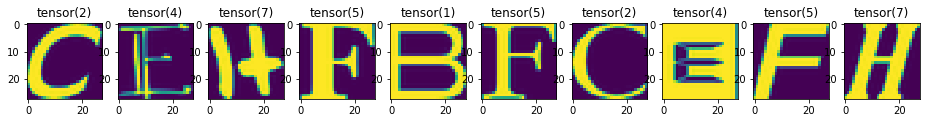

In [320]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[16,4])

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_test[i].reshape([28, 28]))
    plt.title(str(y_test[i]))

In [321]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([14043, 28, 28]),
 torch.Size([14043]),
 torch.Size([4681, 28, 28]),
 torch.Size([4681]))

In [322]:
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

In [323]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([14043, 784]),
 torch.Size([14043]),
 torch.Size([4681, 784]),
 torch.Size([4681]))

The cell below has an example layout for encapsulating your neural network. Feel free to modify the interface if you need to (add arguments, add return values, add methods etc.). For example, you may want to add a method `do_gradient_step()` that executes one optimization algorithm (SGD / Adadelta / Adam / ...) step.

In [324]:
def create_minibatches(X_train, y_train, batchsize):
    ix = torch.LongTensor(batchsize).random_(0, len(X_train))
    x_batch = torch.tensor(X_train[ix], dtype=torch.float32)
    y_batch = torch.tensor(y_train[ix], dtype=torch.float32)
    return x_batch, y_batch

In [325]:
def loss_fn_final(y_predicted, y_batch):
    y_batch = y_batch.long()
    x = y_predicted - y_predicted.max(1)[0].view(y_predicted.shape[0],1)
    out = torch.zeros_like(y_batch, dtype=torch.float)
    out = torch.diag(x[:,y_batch])
    loss = -out.sum()/len(out)
    return loss

In [326]:
class NeuralNet:
    def __init__(self):
        dtype = torch.float32
        device = torch.device("cpu")
        self.w1 = torch.randn(784, 500, device=device, dtype=dtype, requires_grad=True)
        self.w2 = torch.randn(500, 250, device=device, dtype=dtype, requires_grad=True)
        self.w3 = torch.randn(250, 10, device=device, dtype=dtype, requires_grad=True)

    def predict(self, images):
        y_pred = images.mm(self.w1).clamp(min=0).mm(self.w2).clamp(min=0).mm(self.w3)
        return y_pred
        
        
    def train(self, X_train, y_train, batchsize, epoch_number, learning_rate):

        for epoch in range(epoch_number):
            for _ in range(50):
                x_batch, y_batch = create_minibatches(X_train, y_train, batchsize)

                y_predicted = self.predict(x_batch)

                loss = loss_fn_final(y_predicted, y_batch)

                loss.backward()

                with torch.no_grad():
                    self.w1 -= learning_rate * self.w1.grad
                    self.w2 -= learning_rate * self.w2.grad
                    self.w3 -= learning_rate * self.w3.grad
                    self.w1.grad.zero_()
                    self.w2.grad.zero_()
                    self.w3.grad.zero_()

            print('loss %f' % loss)

In [327]:
net = NeuralNet()
# opt = torch.optim.SGD([net.w1, net.w2, net.w3], lr = 0.01, momentum=0.9)
# opt = torch.optim.Adam([net.w1, net.w2, net.w3], lr = 0.0005)
batchsize = 256
epoch_number = 20
learning_rate = 0.001

net.train(X_train, y_train, batchsize, epoch_number, learning_rate)

/home/negvet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/negvet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


loss 464.992645
loss 297.624420
loss 329.708740
loss 283.300629
loss 333.590973
loss 185.746689
loss 188.029022
loss 140.303177
loss 245.718491
loss 197.741638
loss 79.712219
loss 165.163437
loss 130.156738
loss 72.226212
loss 108.454880
loss 60.933285
loss 116.362457
loss 62.337833
loss 122.734169
loss 142.986938


In [328]:
def accuracy(X, y, net):
    y_predicted = net.predict(X)
    _, indices = torch.max(y_predicted,1)
    accuracy = ((indices == y).double().mean())   
    return accuracy

In [329]:
train_acc = accuracy(X_train, y_train, net) * 100
test_acc = accuracy(X_test, y_test, net) * 100
print("Train accuracy: %.2f, test accuracy: %.2f" % (train_acc, test_acc))

assert test_acc >= 82.0, "You have to do better"

Train accuracy: 91.21, test accuracy: 83.83
